In [1]:
import numpy as np

from qiskit import IBMQ, Aer, QuantumCircuit, assemble, transpile
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

In [2]:
n = int(input()) # set the length of the n-bit input string

3


# Constant Oracle

Input has no effect on Output, so just set the output to be 0 or 1

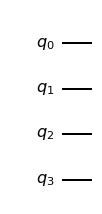

In [3]:
const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

const_oracle.draw()

# Balanced Oracle

Created by performing CNOTs with each input qubit as a control and the output bit as the target. Vary the input states that give 0 or 1 by wrapping some of the controls in X-gates

In [4]:
balanced_oracle = QuantumCircuit(n+1)

In [5]:
print('Enter a string of length ', n)

b_str = input()

Enter a string of length  3
101


Use this string as a key to place our X-gates

For each qubit in our circuit place an X-gate if the corresponding digit is 1, or do nothing if the digit is 0

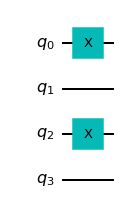

In [6]:
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit) # Place X-gates

balanced_oracle.draw()

Do our controlled-NOT gates using each input qubit as a control and the output qubit as a target

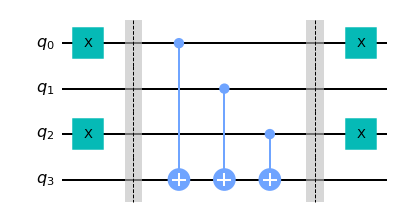

In [7]:
balanced_oracle.barrier() # Use barrier as divider

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()
balanced_oracle.draw()

for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit) # Place X-gates

balanced_oracle.draw() # Show oracle

# Full algorithm

This first step in the algorithm is to initialize the input qubits in the state |+⟩ and the output qubit in the state |−⟩

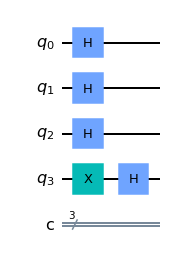

In [8]:
dj_circuit = QuantumCircuit(n+1, n)

for qubit in range(n):
    dj_circuit.h(qubit) # Apply H-gates

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)
dj_circuit.draw()

## Applying balanced Oracle

<ipython-input-9-c26838fd185f>:1: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_circuit += balanced_oracle
/opt/conda/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


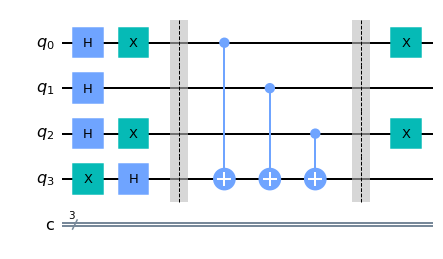

In [9]:
dj_circuit += balanced_oracle
dj_circuit.draw()

Perform H-gates on the n-input qubits and measure our input register

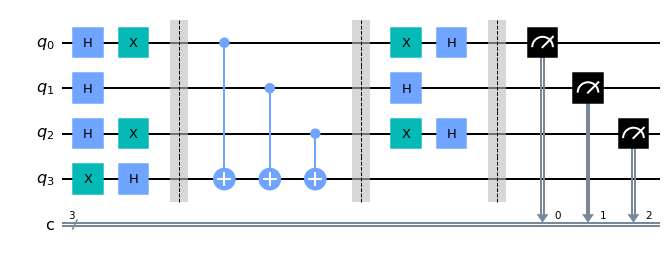

In [10]:
for qubit in range(n):
    dj_circuit.h(qubit) # Repeat H-gates
dj_circuit.barrier()

for i in range(n):
    dj_circuit.measure(i, i) # Measure

dj_circuit.draw() # Display circuit

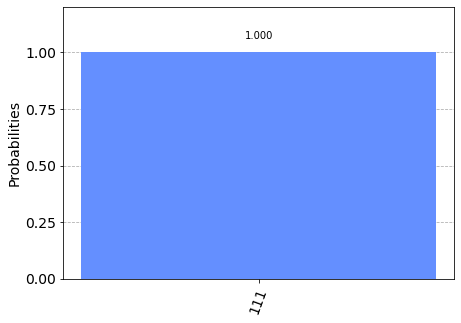

In [11]:
# Output on local simulator
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 1024
qobj = assemble(dj_circuit, qasm_sim)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

0% chance of measuring 000. This shows the function is balanced with 100% accuracy

# Creating generalised circuits

Create Deutsch-Jozsa Oracles and turn them into Quantum gates

In [12]:
def dj_oracle(case, n):
    oracle_qc = QuantumCircuit(n+1)
    
    if case == "balanced":
        b = np.random.randint(1,2**n) # random number that tells us which CNOTs to wrap in X-gates
        b_str = format(b, '0'+str(n)+'b') # format 'b' as a binary string of length 'n' padded with zeros
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit) # apply an X-gate to that qubit
        
        for qubit in range(n):
            oracle_qc.cx(qubit, n) # Controlled-NOT gates for each qubit, using the output qubit as the target
        
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit) # Place the final X-gates

    if case == "constant":
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # Show when we display the circuit
    
    return oracle_gate

# Create a function that takes this Oracle gate and perform the algorithm on it

In [13]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    
    # Set up the output qubit
    dj_circuit.x(n)
    dj_circuit.h(n)
    
    # Set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    dj_circuit.append(oracle, range(n+1)) # Append the oracle gate to the circuit
    for qubit in range(n):
        dj_circuit.h(qubit) # Perform the H-gates
    
    for i in range(n):
        dj_circuit.measure(i, i) # Measure
    
    return dj_circuit

3


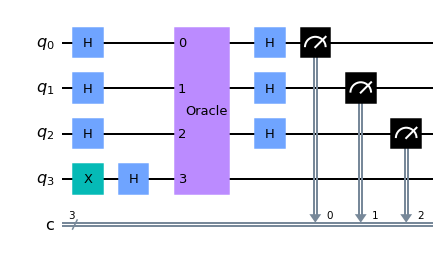

In [14]:
n = int(input())
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

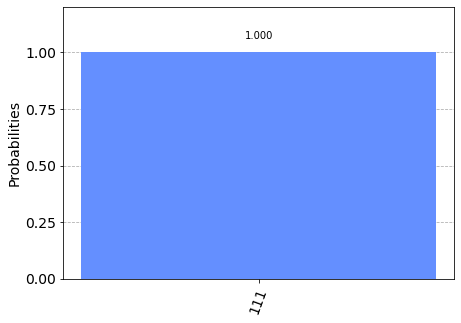

In [15]:
transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)
qobj = assemble(transpiled_dj_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

# Experimenting on Quantum device

In [16]:
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(
    filters=lambda x: x.configuration().n_qubits >= (n+1) and not x.configuration().simulator and x.status().operational==True))

print("least busy backend: ", backend)

least busy backend:  ibmq_16_melbourne


In [17]:
shots = 1024
transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level=3)
qobj = assemble(transpiled_dj_circuit, backend)
job = backend.run(qobj)

job_monitor(job, interval=2)

<ipython-input-17-37cd63fd1a3a>:4: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


Job Status: job has successfully run


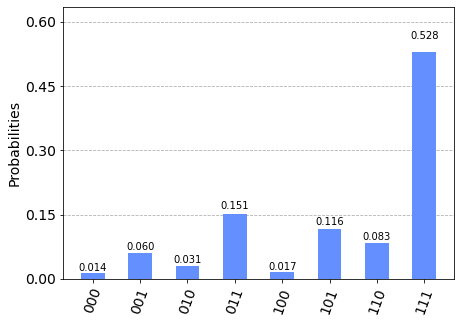

In [18]:
results = job.result()
answer = results.get_counts()

plot_histogram(answer)